# Approximate Factor Models

_UNDER CONSTRUCTION_

- PCA, EM
- Approximate factors and selection: Bai and Ng (2002), McCracken and Ng (2016)


In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from finds.readers.alfred import Alfred, fred_md, fred_qd
from finds.econs import factors_em, mrsq, select_bai_ng, integration_order
from finds.filters import remove_outliers, is_outlier
from finds.unstructured.store import Store
from finds.misc.show import Show
from secret import credentials, paths
show = Show(ndigits=4, latex=None)
VERBOSE = 0
# %matplotlib qt

In [3]:
imgdir = paths['images'] / 'ts'
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=-1)
store = Store(paths['scratch'])


## FRED-MD
- Transformation Codes
- Stationarity, Integration Order

In [4]:
## Transformation Codes, and Stationarity
qd_df, qd_codes = fred_qd() # 202004
md_df, md_codes = fred_md() # 201505
qd_date = max(qd_df.index)
md_date = max(md_df.index)

print(f"Number of series by suggested tcode transformations ({md_date}):")
tcodes = pd.concat([Series(alf.tcode[i], name=i).to_frame().T
                    for i in range(1, 8)], axis=0).fillna(False)
tcodes = tcodes.join(qd_codes['transform'].value_counts().rename('fred-qd'))\
               .join(md_codes['transform'].value_counts().rename('fred-md'))\
               .fillna(0)\
               .astype({'fred-qd': int, 'fred-md': int})\
               .rename_axis(index='tcode')
show(tcodes)

quarterly/current.csv
monthly/current.csv
Number of series by suggested tcode transformations (20230630):


,diff,log,pct_change,fred-qd,fred-md
tcode,,,,,
1,0,0,False,22,11
2,1,0,False,32,19
3,2,0,False,0,0
4,0,1,False,0,10
5,1,1,False,141,53
6,2,1,False,50,33
7,1,0,True,1,1


In [5]:
## Verify integration order
out = {}
for label, df, transforms in [['md', md_df, md_codes['transform']],
                              ['qd', qd_df, qd_codes['transform']]]:
    stationary = dict()
    for series_id, tcode in transforms.items():
        if tcode in range(1, 8):
            s = np.log(df[series_id]) if tcode in [4, 5, 6] else df[series_id]
            order = integration_order(s.dropna(), pvalue=0.05)
            expected_order = 2 if tcode == 7 else ((tcode - 1) % 3)
            stationary[series_id] = {'tcode': tcode,
                                     'I(p)': order,
                                     'different': order - expected_order,
                                     'title': alf.header(series_id)}
#            print(series_id, tcode, expected_order, order)
    stationary = DataFrame.from_dict(stationary, orient='index')
    stationary = stationary.sort_values(stationary.columns.to_list())
    c = stationary.groupby(['tcode','I(p)'])['title'].count().reset_index()
    out[label] = c.pivot(index='tcode', columns='I(p)',
                         values='title').fillna(0).astype(int)
    out[label].columns=[f"I({p})" for p in out[label].columns]

In [6]:
print('Series by tcode, transformations and estimated order of integration:')
results = pd.concat([tcodes.drop(columns='fred-md'),
                     out['qd'],
                     tcodes['fred-md'],
                     out['md']], axis=1).fillna(0).astype(int)
show(results,
     caption='FRED-MD order of integration, transformations and frequency')


Series by tcode, transformations and estimated order of integration:


,diff,log,pct_change,fred-qd,I(0),I(1),I(2),fred-md,I(0),I(1),I(2)
"FRED-MD order of integration, transformations and frequency",,,,,,,,,,,
1,0,0,0,22,18,4,0,11,11,0,0
2,1,0,0,32,10,20,2,19,3,16,0
3,2,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,10,6,4,0
5,1,1,0,141,30,106,5,53,14,39,0
6,2,1,0,50,0,28,22,33,0,29,4
7,1,0,1,1,0,0,1,1,0,1,0


In [7]:
show(stationary[stationary['different'] > 0],
     max_colwidth=60,
     caption='FRED-MD series with unit root after transformations')

,tcode,I(p),different,title
FRED-MD series with unit root after transformations,,,,
NWPI,1,1,1,*** NWPI ***
TLBSNNBBDI,1,1,1,*** TLBSNNBBDI ***
TLBSNNCBBDI,1,1,1,*** TLBSNNCBBDI ***
HWI,1,1,1,Help Wanted Index for United States
GFDEBTN,2,2,1,Federal Debt: Total Public Debt
S&P div yield,2,2,1,S&P's Composite Common Stock: Dividend Yield
CES2000000008,5,2,1,Average Hourly Earnings of Production and Nons...
TLBSHNO,5,2,1,Households and Nonprofit Organizations; Total ...
OPHMFG,5,2,1,Manufacturing Sector: Labor Productivity (Outp...


## Approximate factor model

- Bai and Ng, McCracken and Ng

In [8]:
# Verify BaiNg implemention on published FRED-MD and FRED-QD reports
qd_df, qd_codes = fred_qd(202004)
md_df, md_codes = fred_md(201505)
for freq, df, transforms in [['monthly', md_df, md_codes['transform']],
                             ['quarterly', qd_df, qd_codes['transform']]]:    
    # Apply tcode transformations
    transformed = []
    for col in df.columns:
        transformed.append(alf.transform(df[col],
                                         tcode=transforms[col],
                                         freq=freq[0]))
    data = pd.concat(transformed, axis=1).iloc[2:]
    cols = list(data.columns)
    sample = data.index[((np.count_nonzero(np.isnan(data), axis=1)==0)
                         | (data.index <= 20141231))
                        & (data.index >= 19600301)]

    # set missing and outliers in X to NaN
    X = data.loc[sample]
    X = remove_outliers(X)

    # compute factors EM and auto select number of components, r
    Z = factors_em(X, p=2, verbose=VERBOSE)
    r = select_bai_ng(Z, p=2)
    
    # show marginal R2's of series to each component
    mR2 = mrsq(Z, r).to_numpy()
    show(DataFrame({'selected': r,
                    'variance explained': np.sum(np.mean(mR2[:, :r], axis=0)),
                    'start': min(sample),
                    'end': max(sample),
                    'obs': Z.shape[0],
                    'series': Z.shape[1]},
                   index=[f'factors']),
         caption=f"FRED-{freq[0].upper()}D {freq} series:")

    for k in range(r):
        args = np.argsort(-mR2[:, k])
        show(DataFrame.from_dict({mR2[arg, k].round(4):
                                  {'series': cols[arg],
                                   'description': alf.header(cols[arg])}
                                  for arg in args[:10]},
                                 orient='index'),
             caption=f"Factor:{1+k} Variance Explained={np.mean(mR2[:,k]):.4f}")

quarterly/2020-04.csv
monthly/2015-05.csv


In [9]:
## Sanity check Extract factors: SVD == PCA
# pipe.fit through 20141231, pipe.transform through 20201231

df, t = fred_md()  #202104 # 201505
transforms = t['transform']
sample_date = 20141231
data = []
for col in df.columns:
    data.append(alf.transform(df[col], tcode=transforms[col], freq='m'))
data = pd.concat(data, axis=1).iloc[2:]
cols = list(data.columns)
sample = data.index[((np.count_nonzero(np.isnan(data), axis=1)==0) |
                     (data.index <= sample_date)) & (data.index >= 19600301)]
train_sample = sample[sample <= sample_date]
test_sample = sample[sample <= 20191231]

monthly/current.csv


In [10]:
# replace missing and outliers with PCA EM and fixed number of components r=8
r = 8
X = data.loc[train_sample] # X = np.array(data.loc[train_sample])
X[is_outlier(X, method='iq10')] = np.nan
x = factors_em(X, kmax=r, p=0, verbose=0).to_numpy()

In [11]:
# Extract factors with SVD
y = ((x-x.mean(axis=0).reshape(1,-1))/x.std(axis=0,ddof=0).reshape(1,-1))
u, s, vT = np.linalg.svd(y, full_matrices=False)
#factors = DataFrame(u[:, :r], columns=np.arange(1, 1+r),
#                    index=pd.DatetimeIndex(train_sample.astype(str), freq='M'))
Series(s[:r]**2 / np.sum(s**2), index=np.arange(1, r+1), name='R2').to_frame().T

,1,2,3,4,5,6,7,8
R2,0.151032,0.071875,0.068792,0.056614,0.043291,0.033761,0.031713,0.027361


In [12]:
# Equivalent to sklearn PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(r))])
pipe.fit(x)              # fit model on training data
X = data.loc[sample]     # to transform on full sample data
X = factors_em(X, kmax=8, p=0, verbose=0)  # replace missing (not outlier)
factors = DataFrame(StandardScaler().fit_transform(pipe.transform(X)),
                    index=pd.DatetimeIndex(sample.astype(str), freq='infer'),
                    columns=np.arange(1, 1+r))

# store approximate factors in local folder
store['approximate'] = dict(factors=factors)

/home/terence/env3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [13]:
Series(pipe.named_steps['pca'].explained_variance_ratio_,
       index=np.arange(1,r+1), name='R2').to_frame().T   # sanity check

,1,2,3,4,5,6,7,8
R2,0.151032,0.071875,0.068792,0.056614,0.043291,0.033761,0.031713,0.027361


In [14]:
## Retrieve recession periods from FRED
vspans = alf.date_spans('USREC')
DataFrame(vspans, columns=['Start', 'End'])

,Start,End
0,1854-12-31,1854-12-31
1,1857-06-30,1858-12-31
2,1860-10-31,1861-06-30
3,1865-04-30,1867-12-31
4,1869-06-30,1870-12-31
5,1873-10-31,1879-03-31
6,1882-03-31,1885-05-31
7,1887-03-31,1888-04-30
8,1890-07-31,1891-05-31
9,1893-01-31,1894-06-30


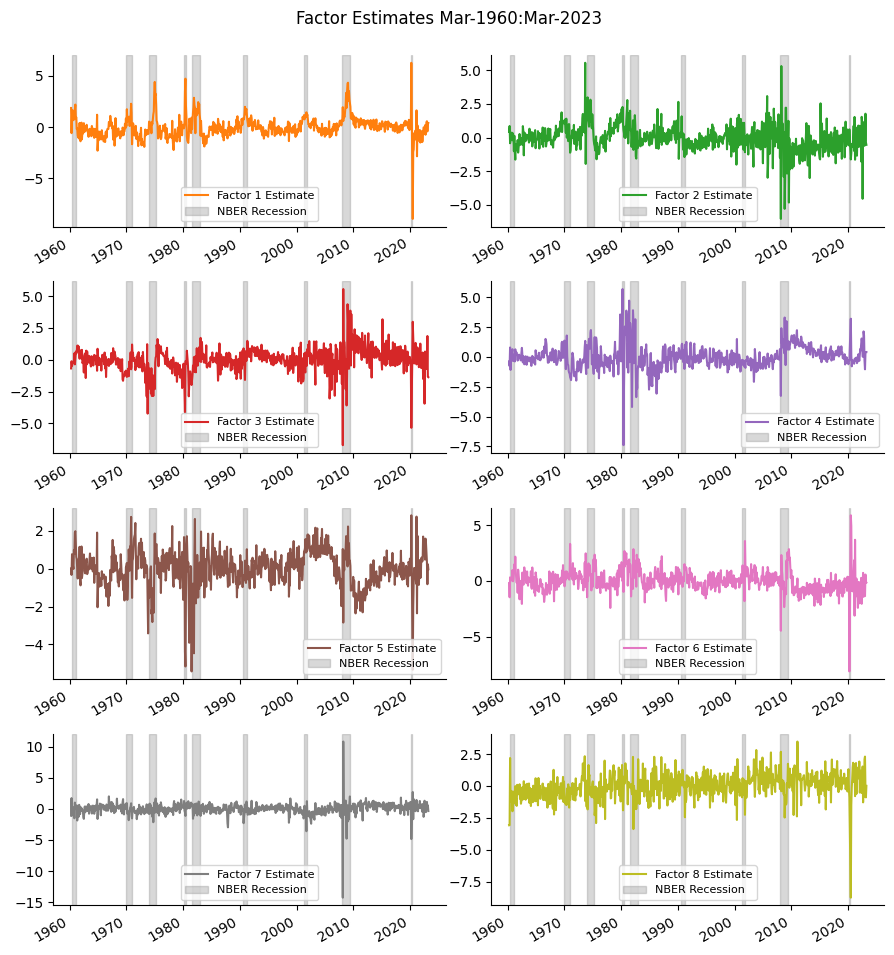

In [15]:
## Plot extracted factors
fig = plt.figure(figsize=(9, 10), num=1, clear=True)
for col in factors.columns:
    ax = fig.add_subplot(4, 2, col)
    flip = -np.sign(max(factors[col]) + min(factors[col])) # try match sign
    (flip*factors[col]).plot(ax=ax, color=f"C{col}")
    for a,b in vspans:
        if b >= min(factors.index):
            ax.axvspan(max(a, min(factors.index)), min(b, max(factors.index)),
                       alpha=0.3, color='grey')
    ax.legend([f"Factor {col} Estimate", 'NBER Recession'], fontsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"Factor Estimates {factors.index[0]:%b-%Y}:"
             f"{factors.index[-1]:%b-%Y}", fontsize=12)
plt.savefig(imgdir / 'approximate.jpg')